# TTK4275 Music Classification Project

## Code: part-by-part

This has to be run from top to buttom, in that order, to guarantee the right result in each cell. E.g. if you only want to look at part 4, you have to run the previously parts first. 

### Part 0: Imports and initialising of features

First we need to initialise a feature structure and load the feature data into it. 
First some necessary imports: 

In [34]:
import re
import numpy as np

import matplotlib.pyplot as plt

from itertools import combinations
import copy

from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier

Then we need to define a SongFeature stuct and define some reading function:

In [4]:
class SongFeatures:
    def __init__(self, arr):
        self.Track_ID,self.File,self.zero_cross_rate_mean,self.zero_cross_rate_std,self.rmse_mean,self.rmse_var,self.spectral_centroid_mean,self.spectral_centroid_var,\
        self.spectral_bandwidth_mean,self.spectral_bandwidth_var,self.spectral_rolloff_mean,self.spectral_rolloff_var,self.spectral_contrast_mean,self.spectral_contrast_var,self.spectral_flatness_mean,\
        self.spectral_flatness_var,self.chroma_stft_1_mean,self.chroma_stft_2_mean,self.chroma_stft_3_mean,self.chroma_stft_4_mean,self.chroma_stft_5_mean,self.chroma_stft_6_mean,self.chroma_stft_7_mean,\
        self.chroma_stft_8_mean,self.chroma_stft_9_mean,self.chroma_stft_10_mean,self.chroma_stft_11_mean,self.chroma_stft_12_mean,self.chroma_stft_1_std,self.chroma_stft_2_std,self.chroma_stft_3_std,\
        self.chroma_stft_4_std,self.chroma_stft_5_std,self.chroma_stft_6_std,self.chroma_stft_7_std,self.chroma_stft_8_std,self.chroma_stft_9_std,self.chroma_stft_10_std,self.chroma_stft_11_std,self.chroma_stft_12_std,\
        self.tempo,self.mfcc_1_mean,self.mfcc_2_mean,self.mfcc_3_mean,self.mfcc_4_mean,self.mfcc_5_mean,self.mfcc_6_mean,self.mfcc_7_mean,self.mfcc_8_mean,self.mfcc_9_mean,self.mfcc_10_mean,self.mfcc_11_mean,\
        self.mfcc_12_mean,self.mfcc_1_std,self.mfcc_2_std,self.mfcc_3_std,self.mfcc_4_std,self.mfcc_5_std,self.mfcc_6_std,self.mfcc_7_std,self.mfcc_8_std,self.mfcc_9_std,self.mfcc_10_std,self.mfcc_11_std,self.mfcc_12_std,\
        self.GenreID,self.Genre,self.Type = arr
        
def readGenreClassData(file_path):
    '''
    Read genre class data from path_to_file and returns a dict of SongFeatures [from TrackID to SongFeature]
    '''
    with open(file_path) as f:
        f.readline() #Remove description
        lines = f.readlines()
    dict_of_SF = dict()
    for str in lines:
        arr = re.split(r'\t+', str.rstrip('\n'))
        arr[0] = int(arr[0])
        arr[-3] = int(arr[-3])
        for i in range(2,len(arr)-3):
            arr[i] = float(arr[i])
        dict_of_SF[arr[0]] = SongFeatures(arr)
    return dict_of_SF

def getPointsAndClasses(songs_dict, features, classes, type):
    '''
    input:  songs_dict  - a dict from id to SongFeature
            features    - array of features to be used
            classes     - array of classes to be used
            type        - "Train" or "Test"
    output: X, y, id_list - X is a np.array of size (N_POINTS, N_FEATURES), 
                            y is a np.array of class ids with size N_POINTS, 
                            id_list is id to corresponding song
    '''
    n_features  = len(features)

    X = np.empty([0,n_features])
    y = np.empty(0,dtype=np.int16)
    id_list = []
    for song in songs_dict.values():
        if song.Type == type and song.Genre in classes:
            x = np.zeros([1,n_features])
            for i in range(n_features):
                x[0,i] = song.__dict__[features[i]]
            X = np.append(X,x,axis = 0)
            y = np.append(y,song.GenreID) 
            id_list.append(song.Track_ID)
    
    return X, y, id_list

def genre_string_to_id(genre):
    '''
    input: genre in string format
    output: genre id
    '''
    genres = ["pop","metal", "disco", "blues", "reggae", "classical", "rock", "hiphop", "country", "jazz"]
    return genres.index(genre)

def genre_id_to_string(genre_id):
    '''
    input: genre_id
    output: genre in string format
    '''
    genres = ["pop","metal", "disco", "blues", "reggae", "classical", "rock", "hiphop", "country", "jazz"]
    return genres[genre_id]

Next step is to actually read from file: 

In [5]:
songs_dict = readGenreClassData("Data/GenreClassData_30s.txt")

### Part 1: Design of KNN classifier

First we designed a KNN classifier class: 

In [6]:
class KNNClassifier:
    def __init__(self, X, y, ids_list, features, k, input_normalisation_type = ""):
        '''
        X               : point nd.array of dimension (N_POINTS, N_FEATURES)
        y               : nd.array of class labels
        ids_list        : array of correspongin track ids 
        features        : array of feature strings
        k               : int 
        should_normalise: "" -> no normalisation, "z_score", "min_max"
        '''
        self.X = X.copy()
        self.y = y.copy()
        self.ids_list = ids_list.copy()
        self.classes_id = list(np.unique(y))
        self.classes = [genre_id_to_string(i) for i in self.classes_id]
        self.num_classes = len(self.classes)
        self.k = k
        self.features = features
        self.dim = len(features)
        self.num_points = np.size(X,0)
        
        #PCA variables:
        self.isPCAused = False
        self.pca_n_components = 0
        
        #Normalisation
        # Keep track of mean, sd, min and max for each feature to normalise
        self.features_mean_sd = [] # array of tuple (mean, sd)
        self.features_min_max = [] # array of tuple (min, max)
        
        self.input_normalisation_type = input_normalisation_type
        if input_normalisation_type == "z_score":
            self.z_score_normalise()
        elif input_normalisation_type == "min_max":
            self.min_max_normalise()
            
    def z_score_normalise(self):
        '''
        Normalises features using z-score normalisation
        '''
        for i in range(self.dim):
            mean = np.mean(self.X[:,i])
            var = np.var(self.X[:,i])
            sd = np.sqrt(var)
            self.X[:,i] = (self.X[:,i]-mean)/sd
            self.features_mean_sd.append((mean,sd))

    def min_max_normalise(self):
        '''
        Normalises features using min-max normalisation
        '''
        for i in range(self.dim):
            min = np.min(self.X[:,i])
            max = np.max(self.X[:,i])
            diff = max - min

            self.X[:,i] = (self.X[:,i]-min)/diff
            self.features_min_max.append((min,max))
        
    def doPCA(self, n_components):
        '''
        Transform points using PCA analysis
        Changes self.points
        '''
        self.isPCAused = True
        self.pca_n_components = n_components

        self.pca = PCA(n_components=n_components)
        self.X = self.pca.fit_transform(self.X)

    def classify(self, x):
        '''
        input: x of type np.array with dim = k (NOT normalised)
        output: genre ID
        '''
        #normalise input if normalisation is enabled
        if self.input_normalisation_type == "z_score":
            for i in range(self.dim):
                x[i] = (x[i]-self.features_mean_sd[i][0])/self.features_mean_sd[i][1]
        elif self.input_normalisation_type == "min_max":
            for i in range(self.dim):
                min = (self.features_min_max[i][0])
                max = self.features_min_max[i][1]
                diff = max-min
                x[i] = (x[i]-min)/diff
        
        #Do PCA transform if PCA is anabled
        if self.isPCAused:
            x = self.pca.transform(x.reshape(1, -1))

        # Calculate distances
        difference = self.X-x
        distances = np.sum(difference*difference,axis=1)
        # k smallest distances: 
        #function gives array of indexes
        index_k_nearest_points = np.argpartition(distances, self.k)[:self.k] 
        distance_k_nearest_points = distances[index_k_nearest_points]

        # Find genres 
        genres_k_nearest_points = []
        for i in index_k_nearest_points:
            genres_k_nearest_points.append(self.y[i])
        
        # Combine data [[index, distance,genre], [index,distance,genre], ...]
        k_nearest_points = [[index_k_nearest_points[i],distance_k_nearest_points[i],
                            genres_k_nearest_points[i]] for i in range(self.k)]
        
        #Count genres
        genres_count = dict()
        for point in k_nearest_points:
            genres_count[point[2]] = genres_count.get(point[2],0) + 1
        genres_count = list(genres_count.items())
        genres_count = sorted(genres_count, key=lambda tup: tup[1], reverse=True)

        #Find genre(s) with most entries, delete the others
        for i in range(1,len(genres_count)):
            if genres_count[i][1] < genres_count[i-1][1]:
                genres_count = genres_count[:i]
                break
        
        genres = [genre[0] for genre in genres_count]

        #Find all points belonging to these genres
        points_to_consider = []
        for point in k_nearest_points:
            if point[2] in genres:
                points_to_consider.append(point)

        #Sort points to consider
        points_to_consider = sorted(points_to_consider, key=lambda x:x[1])

        #Return genre ID with smallest distance
        return points_to_consider[0][2]
    
    def evaluate(self, X_test, y_test, ids_list_test):
        '''
        input: 
        X_test                  : point nd.array of dimension (N_POINTS, N_FEATURES)
        y_test                  : nd.array of class labels
        ids_list_test           : array of correspongin track ids 

        output:
        confusion_matrix        : 2D np array of ints with size (N_CLASSES, N_CLASSES)
        confusion_matrix_list   : 2D array containg lists of classified song ids
        er                      : Error rate          
        '''
        confusion_matrix_list = [[[] for j in range(self.num_classes)] for i in range(self.num_classes)]
        confusion_matrix = np.zeros([self.num_classes,self.num_classes])

        for i in range(len(y_test)):
            genre_id = y_test[i]
            classified_id = self.classify(X_test[i,:])
            correct_index = self.classes_id.index(genre_id)
            predicted_index = self.classes_id.index(classified_id)
            confusion_matrix_list[correct_index][predicted_index].append(ids_list_test[i])
            confusion_matrix[correct_index][predicted_index] +=  1
        er = error_rate(confusion_matrix)
        return confusion_matrix, confusion_matrix_list, er

As well as defining an error rate function:

In [7]:
def error_rate(confusion_matrix):
    '''
    input: confusion matrix as a 2D array
    output: error rate (# of falsely classified points)/( # total points)
    '''
    total = np.sum(confusion_matrix)
    correct = np.sum(np.diagonal(confusion_matrix))
    
    error_rate = (total-correct)/total

    return error_rate

Next we define features and genres we want to use, and extract the training and test set:

In [8]:
features    = ["spectral_rolloff_mean","spectral_centroid_mean","mfcc_1_mean","tempo"]
genres      = ["pop","metal", "disco", "blues", "reggae", "classical", "rock", "hiphop", "country", "jazz"]
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,features, genres, "Test")

Then create a KNN classifier with the training set and evaluate on the test set:

The error rate of KNN without normalisation is:  0.6262626262626263


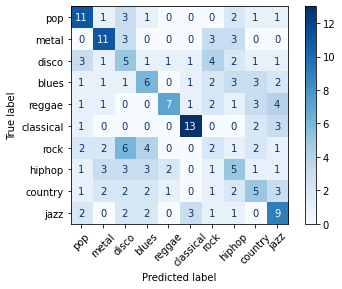

In [9]:
knn = KNNClassifier(X_train, y_train, ids_train, features, 5 ,"")
cm, cm_list, er = knn.evaluate(X_test.copy(),y_test.copy(),ids_test.copy()) 
print("The error rate of KNN without normalisation is: ", er)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

With z score normalisation: 

The error rate of KNN with z-score normalisation is:  0.601010101010101


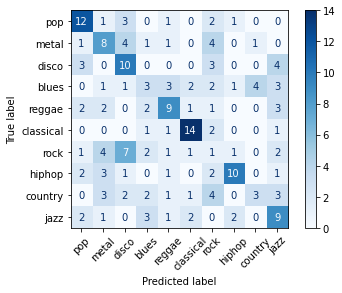

In [10]:
knn = KNNClassifier(X_train, y_train, ids_train, features, 5 ,"z_score")
cm, cm_list, er = knn.evaluate(X_test.copy(),y_test.copy(),ids_test.copy()) 
print("The error rate of KNN with z-score normalisation is: ", er)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

With min-max normalisation:

The error rate of KNN with min-max is:  0.5858585858585859


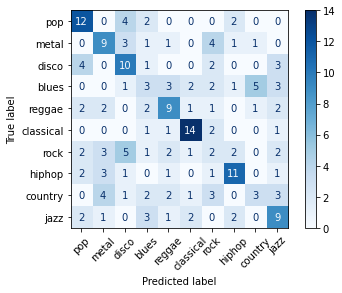

In [11]:
knn = KNNClassifier(X_train, y_train, ids_train, features, 5 ,"min_max")
cm, cm_list, er = knn.evaluate(X_test.copy(),y_test.copy(),ids_test.copy()) 
print("The error rate of KNN with min-max is: ", er)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

### Part 2: Separability

Here we only look at 4 genres in this part, so we have to redefine some variables: 

In [12]:
features    = ["spectral_rolloff_mean","spectral_centroid_mean","mfcc_1_mean","tempo"]
genres      = ["pop", "disco","metal","classical"] 
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,features, genres, "Test")

Implement a histogram plotter: 

In [13]:
def plot_histogram(X , y, features, mode = "separat"):
    '''
    input: 
    X       : Points np.array() with size (N_POINTS,N_FEATURES)
    y       : Class IDs np.array() with size (N_POINTS)
    features: array of features
    mode    : "separat" or "overlayed"

    output:axs_list
    '''
    # Define parameters:
    n_bins = 14
    n_features = len(features)
    n_points = np.size(X,0)
    # Get max and min for each feature
    min_max_features = [] # Array with tuple for min and max for each feature
    for i in range(n_features):
        mm = [0,0]
        mm[0] = np.min(X[:,i])
        mm[1] = np.max(X[:,i])
        min_max_features.append(mm)
    
    # Extract genres from dataset: 
    genre_dict = dict() # Dict from genre ID to np.array of points
    for i in range(n_points):
        genre_id = y[i]
        genre_dict[genre_id] = np.append(genre_dict.get(genre_id, np.empty([0,n_features])), X[i,:].reshape(1,n_features), axis=0)

    n_genres = len(genre_dict)

    axs_list = [None]*n_features
    if mode == "separat":
        for j in range(n_features):
            fig, axs = plt.subplots(n_genres,1,sharey=True, tight_layout=True)
            plt.setp(axs, xlim=(min_max_features[j][0],min_max_features[j][1]), ylim=(0,20))
            i = 0
            for genre_id in genre_dict:
                axs[i].hist(genre_dict[genre_id][:,j], bins = n_bins)
                axs[i].set_title(genre_id_to_string(genre_id))
                i = i + 1
            fig.suptitle(features[j])
            axs_list[j] = axs
        


    elif mode == "overlayed":
        colors = [  (1,0,0,0.5),(0,1,0,0.5),(0,0,1,0.5),(1,1,0,0.5),(1,0,1,0.5),(0,1,1,0.5),
                    (0.95,0.5,0.2,0.5), (0.25,0.75,0.3,0.5),(0.5,0,0,0.5),(0.25,0.4,0.8,0.5)]
        for j in range(n_features):
            fig, axs = plt.subplots(1,1,sharey=True, tight_layout=True)
            plt.setp(axs, xlim=(min_max_features[j][0],min_max_features[j][1]), ylim=(0,20))
            i = 0
            for genre_id in genre_dict:
                axs.hist(genre_dict[genre_id][:,j], bins = n_bins, label = genre_id_to_string(genre_id), fc = colors[i])
                i = i + 1
            fig.suptitle(features[j])
            axs_list[j] = axs

            #Add legends
            axs.legend(loc='best', frameon=False)
            fig.suptitle(features[j])

    return axs_list

Plot the histograms:

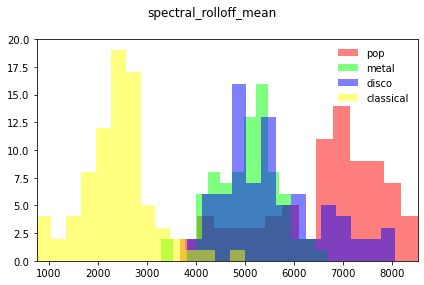

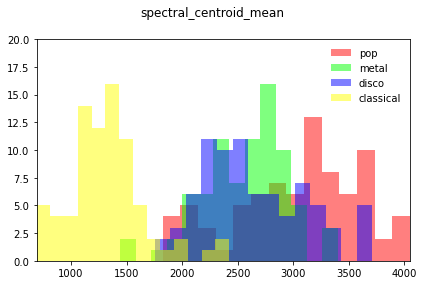

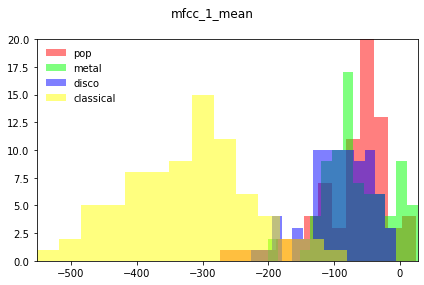

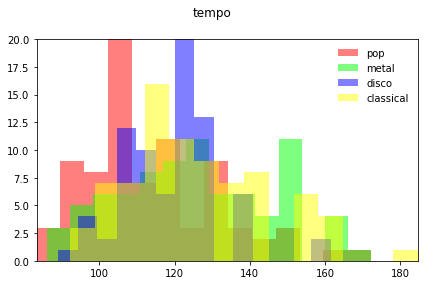

In [14]:
features    = ["spectral_rolloff_mean","spectral_centroid_mean","mfcc_1_mean","tempo"]
axs_list = plot_histogram(X_train, y_train, features, mode = "overlayed")
plt.show()

Create a KNN classifier for each feature selection: 

Chosen features:  ['spectral_rolloff_mean', 'spectral_centroid_mean', 'mfcc_1_mean', 'tempo']
The error rate is:  0.3037974683544304


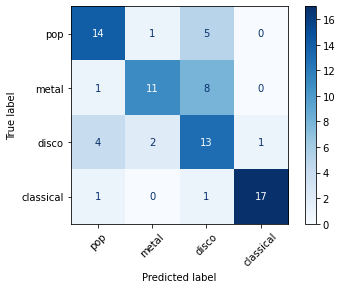

Chosen features:  ['spectral_rolloff_mean', 'spectral_centroid_mean', 'mfcc_1_mean']
The error rate is:  0.25316455696202533


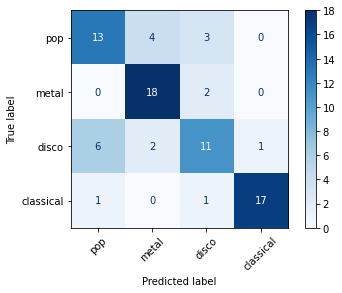

Chosen features:  ['spectral_rolloff_mean', 'spectral_centroid_mean']
The error rate is:  0.27848101265822783


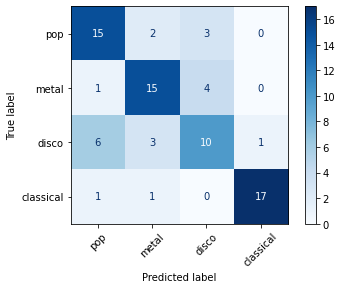

Chosen features:  ['spectral_rolloff_mean']
The error rate is:  0.3924050632911392


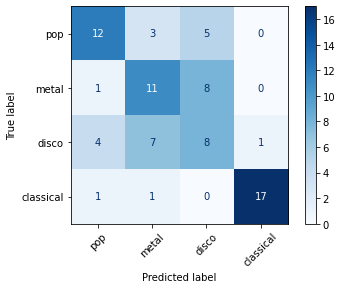

In [15]:
features    = ["spectral_rolloff_mean","spectral_centroid_mean","mfcc_1_mean","tempo"]
print("Chosen features: ", features)
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,features, genres, "Test")
knn = KNNClassifier(X_train, y_train, ids_train, features, 5 ,"min_max")
cm, cm_list, er = knn.evaluate(X_test.copy(),y_test.copy(),ids_test.copy()) 
print("The error rate is: ", er)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

features    = ["spectral_rolloff_mean","spectral_centroid_mean","mfcc_1_mean"]
print("Chosen features: ", features)
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,features, genres, "Test")
knn = KNNClassifier(X_train, y_train, ids_train, features, 5 ,"min_max")
cm, cm_list, er = knn.evaluate(X_test.copy(),y_test.copy(),ids_test.copy()) 
print("The error rate is: ", er)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

features    = ["spectral_rolloff_mean","spectral_centroid_mean"]
print("Chosen features: ", features)
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,features, genres, "Test")
knn = KNNClassifier(X_train, y_train, ids_train, features, 5 ,"min_max")
cm, cm_list, er = knn.evaluate(X_test.copy(),y_test.copy(),ids_test.copy()) 
print("The error rate is: ", er)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

features    = ["spectral_rolloff_mean"]
print("Chosen features: ", features)
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,features, genres, "Test")
knn = KNNClassifier(X_train, y_train, ids_train, features, 5 ,"min_max")
cm, cm_list, er = knn.evaluate(X_test.copy(),y_test.copy(),ids_test.copy()) 
print("The error rate is: ", er)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

*Extra task: separability with PCA*

We also wanted to see how separat the four genres can become with three features. For that we used principal component analysis. 

First we had to create a 3D plotter function:

In [16]:
def plot_3D_feature_space(X , y, features):
        '''
        input
        training_set: a GenreSet
        genres: list of genres to plot
        features: a list of size 3 with features to use

        output
        returns an ac object if dim==3, else nothing
        '''
        if (np.size(X,1) != 3):
            return

        # Define parameters:
        n_features = len(features)
        n_points = np.size(X,0)
        # Get max and min for each feature
        min_max_features = [] # Array with tuple for min and max for each feature
        for i in range(n_features):
            mm = [0,0]
            mm[0] = np.min(X[:,i])
            mm[1] = np.max(X[:,i])
            min_max_features.append(mm)
        
        # Extract genres from dataset: 
        genre_dict = dict() # Dict from genre ID to np.array of points
        for i in range(n_points):
            genre_id = y[i]
            genre_dict[genre_id] = np.append(genre_dict.get(genre_id, np.empty([0,n_features])), X[i,:].reshape(1,n_features), axis=0)
        
        #Init figure
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        for genre in genre_dict:
            ax.scatter(genre_dict[genre][:,0],genre_dict[genre][:,1],genre_dict[genre][:,2],label=genre_id_to_string(genre))

        #Set labels
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(features[2])

        #Add legends
        ax.legend(loc='best', frameon=False)

        return ax

Then we had to do the PC anlysis, plot the 3D feature space and evaluate the confusion matrix with PCA: 

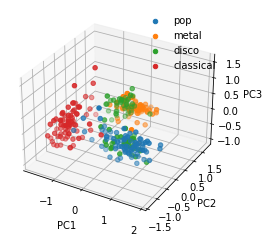

The error rate is:  0.13924050632911392


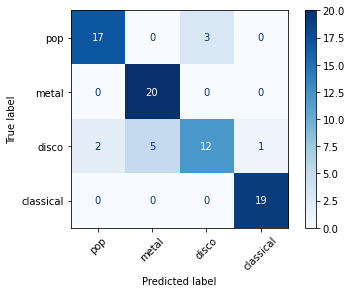

In [17]:
features    = [ "zero_cross_rate_mean","zero_cross_rate_std","rmse_mean","rmse_var","spectral_centroid_mean","spectral_centroid_var","spectral_bandwidth_mean",
                "spectral_bandwidth_var","spectral_rolloff_mean","spectral_rolloff_var","spectral_contrast_mean","spectral_contrast_var","spectral_flatness_mean",
                "spectral_flatness_var","chroma_stft_1_mean","chroma_stft_2_mean","chroma_stft_3_mean","chroma_stft_4_mean","chroma_stft_5_mean","chroma_stft_6_mean",
                "chroma_stft_7_mean","chroma_stft_8_mean","chroma_stft_9_mean","chroma_stft_10_mean","chroma_stft_11_mean","chroma_stft_12_mean","chroma_stft_1_std",
                "chroma_stft_2_std","chroma_stft_3_std","chroma_stft_4_std","chroma_stft_5_std","chroma_stft_6_std","chroma_stft_7_std","chroma_stft_8_std","chroma_stft_9_std",
                "chroma_stft_10_std","chroma_stft_11_std","chroma_stft_12_std","tempo","mfcc_1_mean","mfcc_2_mean","mfcc_3_mean","mfcc_4_mean","mfcc_5_mean","mfcc_6_mean",
                "mfcc_7_mean","mfcc_8_mean","mfcc_9_mean","mfcc_10_mean","mfcc_11_mean","mfcc_12_mean","mfcc_1_std","mfcc_2_std","mfcc_3_std","mfcc_4_std","mfcc_5_std",
                "mfcc_6_std","mfcc_7_std","mfcc_8_std","mfcc_9_std","mfcc_10_std","mfcc_11_std","mfcc_12_std"]

X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

pca = PCA(n_components=3)
X_train = pca.fit_transform(X_train)

ax = plot_3D_feature_space(X_train,y_train,["PC1", "PC2", "PC3"])
plt.show()

X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,features, genres, "Test")
knn = KNNClassifier(X_train, y_train, ids_train, features, 5 ,"min_max")
knn.doPCA(3)
cm, cm_list, er = knn.evaluate(X_test.copy(),y_test.copy(),ids_test.copy()) 
print("The error rate is: ", er)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

### Part 3: Feature selection

We implemented two feature selection methods: one iterative solution using k-fold cross validation and one using the ANOVA f-value as metric for best features. 

#### K-fold Cross Validation

We work again on all genres:

In [18]:
genres      = ["pop","metal", "disco", "blues", "reggae", "classical", "rock", "hiphop", "country", "jazz"]

Define feature pools and make all combinations of pool 1:

In [19]:
feature_pool_1 = ["spectral_centroid_mean","mfcc_1_mean","spectral_rolloff_mean","tempo"]
feature_pool_2 = ["zero_cross_rate_mean","zero_cross_rate_std","rmse_mean","rmse_var","spectral_centroid_mean","spectral_centroid_var","spectral_bandwidth_mean",
"spectral_bandwidth_var","spectral_rolloff_mean","spectral_rolloff_var","spectral_contrast_mean","spectral_contrast_var","spectral_flatness_mean",
"spectral_flatness_var","chroma_stft_1_mean","chroma_stft_2_mean","chroma_stft_3_mean","chroma_stft_4_mean","chroma_stft_5_mean","chroma_stft_6_mean",
"chroma_stft_7_mean","chroma_stft_8_mean","chroma_stft_9_mean","chroma_stft_10_mean","chroma_stft_11_mean","chroma_stft_12_mean","chroma_stft_1_std",
"chroma_stft_2_std","chroma_stft_3_std","chroma_stft_4_std","chroma_stft_5_std","chroma_stft_6_std","chroma_stft_7_std","chroma_stft_8_std","chroma_stft_9_std",
"chroma_stft_10_std","chroma_stft_11_std","chroma_stft_12_std","tempo","mfcc_1_mean","mfcc_2_mean","mfcc_3_mean","mfcc_4_mean","mfcc_5_mean","mfcc_6_mean",
"mfcc_7_mean","mfcc_8_mean","mfcc_9_mean","mfcc_10_mean","mfcc_11_mean","mfcc_12_mean","mfcc_1_std","mfcc_2_std","mfcc_3_std","mfcc_4_std","mfcc_5_std",
"mfcc_6_std","mfcc_7_std","mfcc_8_std","mfcc_9_std","mfcc_10_std","mfcc_11_std","mfcc_12_std"]
feature_pool_1_combinations = list(combinations(feature_pool_1,3))

Define an iterative function that checks all possible feature combinations, calculate average errors on folds and returns the best function:

In [20]:
def k_fold_cross_validation(feature_pool_1_combinations, feature_pool_2):
    best_error_rate = 1
    chosen_features = []
    
    n_splits = 4

    for comb in feature_pool_1_combinations:
        for feature in feature_pool_2:
            features = list(comb) + [feature]
            X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            skf = StratifiedKFold(n_splits=n_splits)
            skf.get_n_splits(X_train, y_train)
            errors = np.zeros(n_splits)
            ei = 0
            for train_index, test_index in skf.split(X_train, y_train):
                knn = KNNClassifier(X_train[train_index,:], y_train[train_index], np.array(ids_train)[train_index], features, 5 ,"min_max")
                cm, cm_list, er = knn.evaluate(X_train[test_index,:].copy(), y_train[test_index].copy(), np.array(ids_train)[test_index].copy())
                errors[ei] = er
                ei = ei + 1

            avg_error = np.average(errors)
            if avg_error < best_error_rate:
                best_error_rate = avg_error
                chosen_features = features
    return chosen_features


Run the function:

**NB - Can take some time**

In [21]:
chosen_features = k_fold_cross_validation(feature_pool_1_combinations, feature_pool_2)
print("Selected features: ")
print(chosen_features)

Selected features: 
['spectral_centroid_mean', 'mfcc_1_mean', 'spectral_rolloff_mean', 'rmse_var']


Evaluate performance:

Error rate:  0.4898989898989899


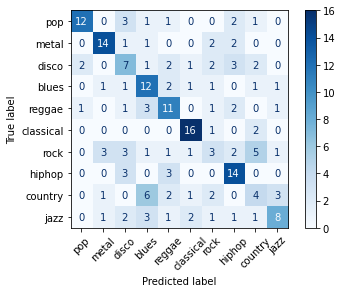

In [22]:
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,chosen_features, genres, "Train")
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,chosen_features, genres, "Test")

knn = KNNClassifier(X_train, y_train, ids_train,chosen_features, 5 ,"min_max")
cm, cm_list, er = knn.evaluate(X_test, y_test, np.array(ids_test).copy())

print("Error rate: ", er)

# Plot confusion matrices
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

#### ANOVA f value feature selection

Initialise variables and calculate scores for each feature:

In [23]:
feature_pool_2 = ["zero_cross_rate_mean","zero_cross_rate_std","rmse_mean","rmse_var","spectral_centroid_mean","spectral_centroid_var","spectral_bandwidth_mean",
"spectral_bandwidth_var","spectral_rolloff_mean","spectral_rolloff_var","spectral_contrast_mean","spectral_contrast_var","spectral_flatness_mean",
"spectral_flatness_var","chroma_stft_1_mean","chroma_stft_2_mean","chroma_stft_3_mean","chroma_stft_4_mean","chroma_stft_5_mean","chroma_stft_6_mean",
"chroma_stft_7_mean","chroma_stft_8_mean","chroma_stft_9_mean","chroma_stft_10_mean","chroma_stft_11_mean","chroma_stft_12_mean","chroma_stft_1_std",
"chroma_stft_2_std","chroma_stft_3_std","chroma_stft_4_std","chroma_stft_5_std","chroma_stft_6_std","chroma_stft_7_std","chroma_stft_8_std","chroma_stft_9_std",
"chroma_stft_10_std","chroma_stft_11_std","chroma_stft_12_std","tempo","mfcc_1_mean","mfcc_2_mean","mfcc_3_mean","mfcc_4_mean","mfcc_5_mean","mfcc_6_mean",
"mfcc_7_mean","mfcc_8_mean","mfcc_9_mean","mfcc_10_mean","mfcc_11_mean","mfcc_12_mean","mfcc_1_std","mfcc_2_std","mfcc_3_std","mfcc_4_std","mfcc_5_std",
"mfcc_6_std","mfcc_7_std","mfcc_8_std","mfcc_9_std","mfcc_10_std","mfcc_11_std","mfcc_12_std"]

# Get points and classes
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,feature_pool_2, genres, "Train")

# Define k_best object
k_best = SelectKBest(k="all")
k_best = k_best.fit(X_train, y_train)

Find the best features that uses at least 3 from the given features: 

In [24]:
# Get scores for each feature and index
scores = np.array(k_best.scores_)
scores_and_index = [(i, scores[i]) for i in range(len(scores))]
scores_and_index = sorted(scores_and_index, key=lambda tup: tup[1], reverse=True)

# Find best features
chosen_features = []
joker_taken = False

for si in scores_and_index:
    idx = si[0]
    feature = feature_pool_2[idx]

    if feature in feature_pool_1:
        chosen_features.append(feature)
    elif joker_taken is False: 
        chosen_features.append(feature)
        joker_taken = True

    if len(chosen_features) == 4:
        break

print("Chosen featues: ", chosen_features)

Chosen featues:  ['mfcc_1_mean', 'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'spectral_centroid_mean']


Evaluate performance:

Error rate:  0.5656565656565656


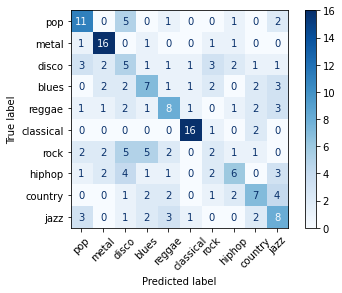

In [25]:
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,chosen_features, genres, "Train")
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,chosen_features, genres, "Test")

knn = KNNClassifier(X_train, y_train, ids_train,chosen_features, 5 ,"min_max")
cm, cm_list, er = knn.evaluate(X_test, y_test, np.array(ids_test).copy())

print("Error rate: ", er)

# Plot confusion matrices
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

### Part 4: A general classifier

Two methods were implemented: maximum log-likelihood of Gaussian mixture models of the data, using feature selection, and a multi layered perceptron, using all features. 

#### Gaussian mixture model classifier
The training to find the best GM takes some time, so this will not be implemented here. This is implemented in task4_GM_trainer.py in the scripts folder. Here we will implement the evaluation of the final GM, when the number of components and number of best features to use have been found.

Again we first initialise features, genres and data:

In [26]:
# Choose features and genres:
features    = [ "zero_cross_rate_mean","zero_cross_rate_std","rmse_mean","rmse_var","spectral_centroid_mean","spectral_centroid_var","spectral_bandwidth_mean",
                "spectral_bandwidth_var","spectral_rolloff_mean","spectral_rolloff_var","spectral_contrast_mean","spectral_contrast_var","spectral_flatness_mean",
                "spectral_flatness_var","chroma_stft_1_mean","chroma_stft_2_mean","chroma_stft_3_mean","chroma_stft_4_mean","chroma_stft_5_mean","chroma_stft_6_mean",
                "chroma_stft_7_mean","chroma_stft_8_mean","chroma_stft_9_mean","chroma_stft_10_mean","chroma_stft_11_mean","chroma_stft_12_mean","chroma_stft_1_std",
                "chroma_stft_2_std","chroma_stft_3_std","chroma_stft_4_std","chroma_stft_5_std","chroma_stft_6_std","chroma_stft_7_std","chroma_stft_8_std","chroma_stft_9_std",
                "chroma_stft_10_std","chroma_stft_11_std","chroma_stft_12_std","tempo","mfcc_1_mean","mfcc_2_mean","mfcc_3_mean","mfcc_4_mean","mfcc_5_mean","mfcc_6_mean",
                "mfcc_7_mean","mfcc_8_mean","mfcc_9_mean","mfcc_10_mean","mfcc_11_mean","mfcc_12_mean","mfcc_1_std","mfcc_2_std","mfcc_3_std","mfcc_4_std","mfcc_5_std",
                "mfcc_6_std","mfcc_7_std","mfcc_8_std","mfcc_9_std","mfcc_10_std","mfcc_11_std","mfcc_12_std"]
genres          = ["pop","metal", "disco", "blues", "reggae", "classical", "rock", "hiphop", "country", "jazz"]

X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")

Normalise and find k best features, where k = 14 has been found from training:

In [27]:
# Create scalers and kbest transform
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
k_best  = SelectKBest(k=14)
X_train = k_best.fit_transform(X_train, y_train)

Define component size of models and create models:

*Most likely a warning will pop up, ignore this.*

In [28]:
model_sizes = {'pop': 1, 'metal': 1, 'disco': 8, 'blues':2, 'reggae':1, 'classical':1, 'rock': 4, 'hiphop': 6, 'country': 1, 'jazz':3}

# Init dict for best models for each genre
best_gmms = dict() # Dict from genre to best gmm for that genre

# Create appropriate model
for genre in genres:
    # Here we fit a GM
    X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, [genre], "Train")
    X_train = scaler.transform(X_train)
    X_train = k_best.transform(X_train)
    gmm = GaussianMixture(n_components=model_sizes[genre], covariance_type="full",init_params='kmeans',random_state=1)
    gmm.fit(X_train)
    best_gmms[genre] = copy.deepcopy(gmm)

C:\Users\finng\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\finng\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\finng\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\finng\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows wi

Evaluate model:

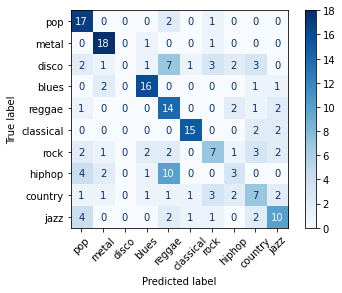

Error rate:  0.4595959595959596


In [29]:
# Get test set
X_test, y_test, ids  = getPointsAndClasses(songs_dict,features, genres, "Test")
# Scale and extract k best features
X_test = scaler.transform(X_test)
X_test = k_best.transform(X_test)

# Compute log likelihood for every function
log_likelihood = np.zeros((len(y_test),len(genres)))
for genre, model in best_gmms.items():
    log_likelihood[:,genres.index(genre)]  = model.score_samples(X_test)

# Find index of best log likelihood
maxVal_ind_rowise = np.argmax(log_likelihood, axis=1)

# Create confusion matrix
cm = np.zeros((len(genres), len(genres)))
for i in range(len(y_test)):
    cm[genres.index(genre_id_to_string(y_test[i])), maxVal_ind_rowise[i]] += 1

# Display confusion matrices
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()

print("Error rate: ", error_rate(cm))

#### Multi layer perceptron classifier
Again the model finding procedure took some time. The file task4_NN_trainer.py holds the training algorithm. Here we implement the final network, and evaluate it. 

Again we start with defining features and genres:

In [30]:
features    = [ "zero_cross_rate_mean","zero_cross_rate_std","rmse_mean","rmse_var","spectral_centroid_mean","spectral_centroid_var","spectral_bandwidth_mean",
                "spectral_bandwidth_var","spectral_rolloff_mean","spectral_rolloff_var","spectral_contrast_mean","spectral_contrast_var","spectral_flatness_mean",
                "spectral_flatness_var","chroma_stft_1_mean","chroma_stft_2_mean","chroma_stft_3_mean","chroma_stft_4_mean","chroma_stft_5_mean","chroma_stft_6_mean",
                "chroma_stft_7_mean","chroma_stft_8_mean","chroma_stft_9_mean","chroma_stft_10_mean","chroma_stft_11_mean","chroma_stft_12_mean","chroma_stft_1_std",
                "chroma_stft_2_std","chroma_stft_3_std","chroma_stft_4_std","chroma_stft_5_std","chroma_stft_6_std","chroma_stft_7_std","chroma_stft_8_std","chroma_stft_9_std",
                "chroma_stft_10_std","chroma_stft_11_std","chroma_stft_12_std","tempo","mfcc_1_mean","mfcc_2_mean","mfcc_3_mean","mfcc_4_mean","mfcc_5_mean","mfcc_6_mean",
                "mfcc_7_mean","mfcc_8_mean","mfcc_9_mean","mfcc_10_mean","mfcc_11_mean","mfcc_12_mean","mfcc_1_std","mfcc_2_std","mfcc_3_std","mfcc_4_std","mfcc_5_std",
                "mfcc_6_std","mfcc_7_std","mfcc_8_std","mfcc_9_std","mfcc_10_std","mfcc_11_std","mfcc_12_std"]
genres      = ["pop","metal", "disco", "blues", "reggae", "classical", "rock", "hiphop", "country", "jazz"]

Get the right data and scale:

In [31]:
X_train, y_train, ids_train  = getPointsAndClasses(songs_dict,features, genres, "Train")

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

Create classifier and fit the data:

In [35]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,activation="logistic", max_iter=100000,verbose=False,
                                hidden_layer_sizes=(40,), random_state=1)
clf = clf.fit(X_train, y_train)

Evaluate classifier:

Error rate:  0.24242424242424243


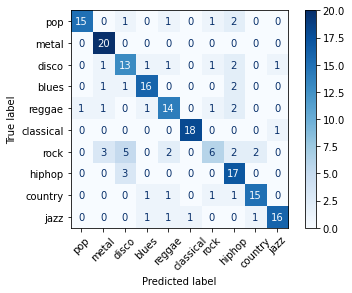

In [36]:
X_test, y_test, ids_test  = getPointsAndClasses(songs_dict,features, genres, "Test")
X_test = scaler.transform(X_test)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Error rate: ", error_rate(cm))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.show()